# **Proyecto Semestral - MDS7202: Laboratorio de Programaci√≥n Cient√≠fica para Ciencia de Datos**


**Integrantes:**

- **Cristian Oyarzo M.**
- **Sebasti√°n Quenti A.**


## **Configuraci√≥n e Importaci√≥n de Librer√≠as**

En esta secci√≥n, se importar√°n las librer√≠as necesarias para el desarrollo y an√°lisis del proyecto.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import optuna
from optuna.visualization import plot_param_importances
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from ydata_profiling import ProfileReport
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

import mlflow
import mlflow.sklearn
from zipfile import ZipFile
import os
import joblib

import shap


## **Introducci√≥n**

El presente proyecto se centra en el desarrollo de un modelo predictivo capaz de estimar la **probabilidad de morosidad** de los clientes de un banco. El objetivo principal es identificar aquellos clientes que son m√°s propensos a incumplir en sus pagos, permitiendo a la instituci√≥n financiera tomar decisiones informadas para gestionar riesgos y maximizar ingresos.

Los datos utilizados corresponden a los archivos con los conjuntos ($X_{t0}$, $y_{t0}$), ($X_{t1}$, $y_{t1}$) y ($X_{t2}$, $y_{t2}$). Cabe destacar que inicialmente no se dispon√≠a de todos estos archivos y que, a medida que se profundiza en este informe, se utilizan m√°s datos. Tambi√©n, inicialmente no exist√≠a un balance de clases en ($X_{t0}$, $y_{t0}$); sin embargo, en los dem√°s archivos exist√≠a desbalance de clases, con clase predominante la negativa (no morosidad).

Los conjunto de datos incluye variables relacionadas con el perfil financiero y comportamental de los clientes. Estas variables abarcan tanto datos num√©ricos (por ejemplo, n√∫mero de transacciones o el tiempo de existencia de una billetera) como categ√≥ricos (por ejemplo, *market_ht_trendmode*, que indica el modo de tendencia Hilbert del mercado).

Se seleccion√≥ el **√Årea Bajo la Curva de Precisi√≥n-Recall (AUC-PR)** como m√©trica principal para evaluzar los modelos. Esta m√©trica se centra en el rendimiento de la clase positiva (clientes morosos) y mide la capacidad del modelo para identificar correctamente a los clientes de alto riesgo mientras minimiza los falsos positivos. La AUC-PR es especialmente adecuada para problemas desbalanceados. Adem√°s, el c√°lculo del AUC-PR nos brinda una herramienta para evaluar de manera efectiva el rendimiento de nuestro modelo, tomando en cuenta los umbrales y el impacto de las decisiones en escenarios cr√≠ticos. 

El AUC-PR, es una m√©trica que es particularmente √∫til cuando buscamos analizar el rendimiento del modelo al variar los umbrales de decisi√≥n (thresholds) en la predicci√≥n de probabilidades, lo que justifica a√∫n m√°s su elecci√≥n. Adem√°s, se consideran m√©tricas complementarias como la precision y el recall, que contribuyen a una interpretaci√≥n m√°s completa del rendimiento del modelo.

Previo al entrenamiento de los modelos, se realizaron transformaciones intermedias mediante **pipelines** y **ColumnTransformers**. Estas incluyeron la imputaci√≥n de valores faltantes, la eliminaci√≥n de variables redundantes y el escalado de las variables num√©ricas, asegurando una adecuada preparaci√≥n de los datos para el modelado. Este enfoque estructurado permite garantizar resultados consistentes y alineados con los objetivos del proyecto.

Para resolver el problema, inicialmente se utilizaron cuatro modelos supervisados:
1. **XGBoost**: Un modelo basado en boosting, altamente eficiente para problemas con datos tabulares.
2. **CatBoost**: Destacado por manejar datos categ√≥ricos de forma nativa y eficiente.
3. **LightGBM**: Una opci√≥n r√°pida y eficaz para conjuntos de datos grandes.
4. **Regresi√≥n Log√≠stica**: Utilizada como referencia base para establecer una l√≠nea base comparativa.

En etapas avanzadas del proyecto se decidi√≥ centrar los esfuerzos en XGBoost debido a su buen desempe√±o inicial y su fama por ser altamente eficiente y robusto en problemas de clasificaci√≥n.

El proyecto arroj√≥ resultados satisfactorios. En las tres etapas del proyecto se alcanzaron valores de AUC-PR de 0.7914172453, 0.853889004 y 0.7510044866, posicion√°ndonos en los lugares 5¬∞, 8¬∞ y 2¬∞ respectivamente (al momento de redactar esta introducci√≥n) de entre aproximadamente 20 equipos participantes. No obstante, estos resultados podr√≠an haber sido mejores con m√°s tiempo disponible, lo que indica que hay margen de mejora en la metodolog√≠a empleada.

---
## **Preprocesamiento**

### **An√°lisis exploratorio de datos**

Se cargan los datos proporcionados para la primera etapa del proyecto.

In [2]:
df_x0 = pd.read_parquet('X_t0.parquet')
df_x1 = pd.read_parquet('X_t1.parquet')
df_y0 = pd.read_parquet('y_t0.parquet')

A continuaci√≥n se listan la totalidad de variables en la base de datos:
1. **borrow_block_number**: N√∫mero de bloque en el que ocurri√≥ el pr√©stamo.
2. **borrow_timestamp**: Marca temporal que indica el momento del pr√©stamo.
3. **wallet_address**: Direcci√≥n de la billetera asociada a las transacciones.
4. **first_tx_timestamp**: Fecha y hora de la primera transacci√≥n registrada de la billetera.
5. **last_tx_timestamp**: Fecha y hora de la √∫ltima transacci√≥n registrada de la billetera.
6. **wallet_age**: Tiempo de existencia de la billetera en d√≠as.
7. **incoming_tx_count**: Cantidad total de transacciones entrantes a la billetera.
8. **outgoing_tx_count**: Cantidad total de transacciones salientes desde la billetera.
9. **net_incoming_tx_count**: Diferencia neta entre transacciones entrantes y salientes.
10. **total_gas_paid_eth**: Suma total de gas pagado en Ethereum (ETH) por la billetera.
11. **avg_gas_paid_per_tx_eth**: Promedio de gas pagado por transacci√≥n en ETH.
12. **risky_tx_count**: Cantidad de transacciones clasificadas como riesgosas.
13. **risky_unique_contract_count**: N√∫mero √∫nico de contratos asociados con transacciones riesgosas.
14. **risky_first_tx_timestamp**: Marca temporal de la primera transacci√≥n riesgosa registrada.
15. **risky_last_tx_timestamp**: Marca temporal de la √∫ltima transacci√≥n riesgosa registrada.
16. **risky_first_last_tx_timestamp_diff**: Diferencia de tiempo entre la primera y la √∫ltima transacci√≥n riesgosa.
17. **risky_sum_outgoing_amount_eth**: Suma total de ETH saliente en transacciones riesgosas.
18. **outgoing_tx_sum_eth**: Suma total de ETH saliente en todas las transacciones.
19. **incoming_tx_sum_eth**: Suma total de ETH entrante en todas las transacciones.
20. **outgoing_tx_avg_eth**: Promedio de ETH saliente por transacci√≥n.
21. **incoming_tx_avg_eth**: Promedio de ETH entrante por transacci√≥n.
22. **max_eth_ever**: M√°ximo balance en ETH registrado en la billetera.
23. **min_eth_ever**: M√≠nimo balance en ETH registrado en la billetera.
24. **total_balance_eth**: Balance total actual de la billetera en ETH.
25. **risk_factor**: Factor de riesgo calculado para la billetera.
26. **total_collateral_eth**: Colateral total en ETH asociado a la billetera.
27. **total_collateral_avg_eth**: Promedio de colateral total en ETH.
28. **total_available_borrows_eth**: Cantidad total de ETH disponible para pr√©stamos.
29. **total_available_borrows_avg_eth**: Promedio de ETH disponible para pr√©stamos.
30. **avg_weighted_risk_factor**: Promedio ponderado del factor de riesgo.
31. **risk_factor_above_threshold_daily_count**: N√∫mero de d√≠as en que el factor de riesgo estuvo por encima de un umbral.
32. **avg_risk_factor**: Promedio general del factor de riesgo.
33. **max_risk_factor**: Valor m√°ximo del factor de riesgo registrado.
34. **borrow_amount_sum_eth**: Suma total de los montos prestados en ETH.
35. **borrow_amount_avg_eth**: Promedio de los montos prestados en ETH.
36. **borrow_count**: N√∫mero total de transacciones de pr√©stamo.
37. **repay_amount_sum_eth**: Suma total de los montos reembolsados en ETH.
38. **repay_amount_avg_eth**: Promedio de los montos reembolsados en ETH.
39. **repay_count**: N√∫mero total de transacciones de reembolso.
40. **borrow_repay_diff_eth**: Diferencia entre el monto prestado y el reembolsado en ETH.
41. **deposit_count**: N√∫mero total de dep√≥sitos realizados.
42. **deposit_amount_sum_eth**: Suma total de los dep√≥sitos en ETH.
43. **time_since_first_deposit**: Tiempo transcurrido desde el primer dep√≥sito registrado.
44. **withdraw_amount_sum_eth**: Suma total de los retiros en ETH.
45. **withdraw_deposit_diff_if_positive_eth**: Diferencia positiva entre retiros y dep√≥sitos en ETH.
46. **liquidation_count**: N√∫mero total de liquidaciones registradas.
47. **time_since_last_liquidated**: Tiempo transcurrido desde la √∫ltima liquidaci√≥n.
48. **liquidation_amount_sum_eth**: Suma total en ETH liquidada.
49. **market_adx**: √çndice direccional promedio del mercado.
50. **market_adxr**: √çndice direccional promedio suavizado del mercado.
51. **market_apo**: Oscilador del precio promedio del mercado.
52. **market_aroonosc**: Oscilador de Aroon para el mercado.
53. **market_aroonup**: Valor de Aroon-Up del mercado.
54. **market_atr**: Rango verdadero promedio del mercado.
55. **market_cci**: √çndice de canal de productos b√°sicos del mercado.
56. **market_cmo**: Oscilador de momento de Chande del mercado.
57. **market_correl**: Correlaci√≥n del mercado.
58. **market_dx**: √çndice direccional del mercado.
59. **market_fastk**: Componente r√°pido K del estoc√°stico del mercado.
60. **market_fastd**: Componente r√°pido D del estoc√°stico del mercado.
61. **market_ht_trendmode**: Modo de tendencia Hilbert del mercado.
62. **market_linearreg_slope**: Pendiente de la regresi√≥n lineal del mercado.
63. **market_macd_macdext**: Componente MACD extendido del mercado.
64. **market_macd_macdfix**: Componente MACD fijo del mercado.
65. **market_macd**: L√≠nea MACD del mercado.
66. **market_macdsignal_macdext**: Se√±al MACD extendida del mercado.
67. **market_macdsignal_macdfix**: Se√±al MACD fija del mercado.
68. **market_macdsignal**: L√≠nea de se√±al MACD del mercado.
69. **market_max_drawdown_365d**: M√°xima ca√≠da en 365 d√≠as del mercado.
70. **market_natr**: Rango verdadero promedio normalizado del mercado.
71. **market_plus_di**: Indicador direccional positivo del mercado.
72. **market_plus_dm**: Movimiento direccional positivo del mercado.
73. **market_ppo**: Oscilador de porcentaje de precio del mercado.
74. **market_rocp**: Cambio porcentual del precio del mercado.
75. **market_rocr**: Relaci√≥n de cambio porcentual del mercado.
76. **unique_borrow_protocol_count**: N√∫mero √∫nico de protocolos de pr√©stamo utilizados.
77. **unique_lending_protocol_count**: N√∫mero √∫nico de protocolos de pr√©stamo activos.
78. **target**: Variable objetivo que indica el estado de morosidad del cliente.


Para el An√°lisis Exploratorio de Datos (EDA) se utiliz√≥ la herramienta de generaci√≥n autom√°tica de perfiles con el siguiente c√≥digo:

In [3]:
# profile = ProfileReport(
#     df_x0,
#     title="An√°lisis Exploratorio de Datos Autom√°tico",
#     explorative=True
# )

# # Guarda el informe como un archivo HTML
# profile.to_file("EDA_Reporte.html")

Debido a la alt√≠sima cantidad de variables en los datos, esta herramienta permite generar un informe detallado que incluye estad√≠sticas descriptivas, detecci√≥n de valores faltantes, correlaciones, distribuciones y otros aspectos clave de los datos, facilitando una comprensi√≥n global y eficiente de la informaci√≥n disponible. Este reporte ser√° anexado a la entrega.

In [4]:
df_y0['target'].value_counts()

target
1    22656
0    21640
Name: count, dtype: int64

En el an√°lisis general de la base de datos se identificaron 73 variables num√©ricas y 3 variables categ√≥ricas, todas ellas sin valores nulos. Adem√°s, se identific√≥ que la variable '*wallet_address*' corresponde a tipo id.

Algunas de las variables siguen una distribuci√≥n similar a normal como '*market_macd_macdext*', '*market_apo*' o '*market_linearreg_slope*'. Estas variables est√°n asociadas principalmente al mercado.

Otras variables como liquidation_amount_sum_eth o withdraw_deposit_diff_if_positive_eth tienen un porcentaje alto de ceros, pese a ser n√∫mericas reales. Estas variables est√°n asociadas generalmente a los ETH.

Realizando un `value_counts` a la columna target de **y_t0** se obtuvo que las clases se encuentran balanceadas, ya que son 22656 valores en 1 y 21640 valores en 0.

Se fija una semilla aleatoria para garantizar la reproducibilidad de los resultados a lo largo del desarrollo del proyecto:

In [5]:
rd = 1323

### **Preprocesamiento de Datos**

En esta etapa, se prepara el pipeline para preprocesar los datos de aqu√≠ en adelante


In [6]:
# Transformador personalizado para eliminar columnas espec√≠ficas
class DropColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.drop(columns=self.columns_to_drop, errors='ignore')

# Columnas categ√≥ricas y num√©ricas
categorical_features = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
numerical_features = [col for col in df_x0.columns if col not in categorical_features + ['wallet_address']]

# Pipeline para las variables num√©ricas
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores nulos con la media
    ('scaler', MinMaxScaler())                   # Min-Max Scaler
])

# Aplicar ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),  # Aplicar transformaci√≥n a num√©ricas
        ('cat', 'passthrough', categorical_features)      # No hacer nada a las categ√≥ricas
    ]
)
preprocessor.set_output(transform="pandas")

# Pipeline general para el preprocesamiento completo
full_pipeline = Pipeline(steps=[
    ('drop_column', DropColumnTransformer(columns_to_drop=['wallet_address'])),  # Eliminar 'wallet_address'
    ('preprocessor', preprocessor)
])

#### Justificaci√≥n del Pipeline

La implementaci√≥n de estos pipelines est√° dise√±ada para preparar los datos de forma eficiente y estructurada. A continuaci√≥n, se detallan y justifican las decisiones tomadas en cada etapa del pipeline:

1. **Eliminaci√≥n de la columna _'wallet_address'_**:  
   Esta columna contiene identificadores √∫nicos que no aportan valor predictivo al problema, ya que no est√°n relacionadas con las caracter√≠sticas del cliente o su probabilidad de morosidad. Adem√°s, conservarla podr√≠a introducir ruido o sesgo en el modelo, especialmente en algoritmos que analizan patrones num√©ricos. No se decidi√≥ eliminar m√°s columnas o una posible reducci√≥n de dimsionalidad, para entregar la mayor cantidad de informaci√≥n a los modelos, adem√°s los modelos ser√°n en su mayor√≠a basados en √°rboles, que manejan generalmente bien la alta dimensionalidad.

2. **Imputaci√≥n de valores nulos en variables num√©ricas**: 
   Si bien inicialmente no se identificaron valores nulos, para evitar que la presencia de nulos en un futuro afecte negativamente el rendimiento de los modelos, se utiliza un imputador que reemplaza los valores faltantes con la media de cada columna. Este m√©todo es adecuado porque mantiene la distribuci√≥n central de las variables sin introducir sesgos significativos, especialmente en conjuntos de datos relativamente grandes.

3. **Normalizaci√≥n de variables num√©ricas con `MinMaxScaler`**:  
   La normalizaci√≥n ajusta los valores al rango [0, 1], lo que asegura que todas las caracter√≠sticas num√©ricas tengan la misma escala. Esto es particularmente importante en modelos basados en distancias (como SVM) y algoritmos que son sensibles a la magnitud de las variables (como regresiones log√≠sticas o redes neuronales).

4. **No transformaci√≥n de variables categ√≥ricas**:  
   Las tres variables categ√≥ricas seleccionadas (_'market_ht_trendmode'_, _'unique_borrow_protocol_count'_, _'unique_lending_protocol_count'_) son binarias. Por lo tanto, no se aplica `OneHotEncoder` ni t√©cnicas similares, ya que ser√≠a redundante e innecesario.


#### Divisi√≥n inicial de los datos

A continuaci√≥ns se divide el conjunto de datos en tres partes para garantizar una evaluaci√≥n adecuada del modelo:

- **70%** para entrenamiento: Utilizado para ajustar los modelos.
- **30%** para prueba: Reservado para evaluar el rendimiento de los modelos.


In [7]:
# Divisi√≥n en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(df_x0, df_y0, test_size=0.3, random_state=rd, stratify=df_y0)

# Asegurarse de que los vectores objetivo sean de una dimensi√≥n y las variables n√∫mericas sean tipo float (compatiblidad con librerias usadas m√°s adelante)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test) 
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes(include=['int']).columns})
X_test = X_test.astype({col: 'float64' for col in X_test.select_dtypes(include=['int']).columns})

---
## **Modelamiento**

Se comienza la construcci√≥n y evaluaci√≥n de modelos predictivos con el objetivo de estimar la probabilidad de morosidad de los clientes (datos etapa 1).


M√©trica utilizada (AUC-PR, tal y como se menciona en la introducci√≥n):

In [8]:
# Definir una m√©trica personalizada para AUC-PR
def custom_auc_pr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

# Crear un scorer basado en la m√©trica personalizada
auc_pr_scorer = make_scorer(custom_auc_pr, response_method = 'predict_proba')

In [9]:
# Configurar el experimento en MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Etapa 1 Proyecto")

<Experiment: artifact_location='mlflow-artifacts:/577771263515207601', creation_time=1733977003079, experiment_id='577771263515207601', last_update_time=1733977003079, lifecycle_stage='active', name='Etapa 1 Proyecto', tags={}>

Para este experimento, se emplea la t√©cnica de GridSearch con validaci√≥n cruzada para determinar la combinaci√≥n √≥ptima de hiperpar√°metros para cada modelo. GridSearch permite explorar de manera sistem√°tica un rango predefinido de configuraciones, evaluando el rendimiento del modelo en cada una de ellas. La m√©trica seleccionada para esta optimizaci√≥n es el AUC-PR, ideal para problemas desbalanceados, ya que se enfoca en la capacidad del modelo para identificar correctamente la clase positiva, tal y como se mencion√≥ en la introducci√≥n.

La validaci√≥n cruzada utilizada es de tipo estratificada, con k=5 pliegues. Esto significa que el conjunto de entrenamiento se divide en 5 subconjuntos (pliegues), y en cada iteraci√≥n, uno de estos subconjuntos se reserva para validaci√≥n, mientras que los otros 4 se usan para entrenamiento. Este enfoque garantiza que cada observaci√≥n se utilice tanto para entrenamiento como para validaci√≥n, proporcionando una evaluaci√≥n robusta del modelo y minimizando el riesgo de sobreajuste. La estratificaci√≥n asegura adem√°s que la proporci√≥n de clases se mantenga consistente en cada pliegue, un factor crucial en datasets desbalanceados.



#### **Modelo Base: Regresi√≥n Log√≠stica**

Se selecciona la Regresi√≥n Log√≠stica como modelo base debido a su simplicidad, rapidez y efectividad en problemas de clasificaci√≥n binaria. Su rendimiento razonable y su bajo costo computacional lo convierten en una herramienta ideal para establecer un punto de referencia antes de implementar otros modelos.

La **Regresi√≥n Log√≠stica** es un modelo estad√≠stico utilizado para problemas de clasificaci√≥n binaria, donde el objetivo es predecir la probabilidad de pertenencia a una de dos clases. Este modelo asume una relaci√≥n lineal entre las variables independientes (predictoras) y el logaritmo de las probabilidades (odds ratio) de la clase positiva. La salida de la regresi√≥n log√≠stica es una probabilidad en el rango [0, 1], que puede transformarse en una predicci√≥n de clase mediante un umbral (por defecto, 0.5). 

En este experimento, se ajustaron dos hiperpar√°metros clave de la Regresi√≥n Log√≠stica:

1. **`C` (Inverso de la Regularizaci√≥n)**:  
   - Controla la fuerza de la regularizaci√≥n L2 aplicada al modelo.
   - Valores peque√±os (`C < 1`) aplican una mayor penalizaci√≥n, reduciendo la complejidad del modelo y previniendo el sobreajuste.
   - Valores altos (`C > 1`) disminuyen la regularizaci√≥n, permitiendo un ajuste m√°s preciso a los datos de entrenamiento.

2. **`penalty` (Tipo de Regularizaci√≥n)**:  
   - Se evaluaron dos tipos de regularizaci√≥n:
     - **`l1` (Lasso)**: Promueve la selecci√≥n de caracter√≠sticas al forzar coeficientes de predictores irrelevantes a ser exactamente cero.
     - **`l2` (Ridge)**: Reduce el tama√±o de los coeficientes para todas las caracter√≠sticas, ayudando a manejar multicolinealidad y prevenir el sobreajuste.

Estos hiperpar√°metros se seleccionaron porque influyen directamente en la capacidad del modelo para generalizar y manejar datos con alta dimensionalidad o correlaci√≥n entre caracter√≠sticas. Se utiliz√≥ una grilla limitada al tratarse de un modelo base.

In [10]:
# Definir modelo base
pipeline_bl = Pipeline([
    ('preprocessing', full_pipeline),
    ('log_reg', LogisticRegression(random_state=rd, solver='liblinear'))
])

# Definir grilla de hiperpar√°metros (Se utiliza una grilla limitada al tratarse de un baseline)
param_grid = {
    'log_reg__C': [1, 10],  
    'log_reg__penalty': ['l1', 'l2']  
}

# Configurar la validaci√≥n cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_bl,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1) 
with mlflow.start_run(run_name="Regresi√≥n log√≠stica - Primera Iteraci√≥n"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores par√°metros
    best_params = grid_search.best_params_
    print(f"Mejores par√°metros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_lr = grid_search.best_estimator_
    y_test_pred = best_model_lr.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular m√©tricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_lr, 
        artifact_path="LogisticRegressionModel", 
        input_example=input_example
    )

    print("Modelo y m√©tricas registrados en MLflow.")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores par√°metros: {'log_reg__C': 10, 'log_reg__penalty': 'l1'}
AUC-PR en el conjunto de test: 0.863254809398311


c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y m√©tricas registrados en MLflow.
üèÉ View run Regresi√≥n log√≠stica - Primera Iteraci√≥n at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/0a96c24ab3c04733886aa1b2f3dd0bbc
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuaci√≥n se presenta el *classification_report* del modelo:

In [11]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.73      0.78      0.76      6492
   Clase Morosa       0.78      0.72      0.75      6797

       accuracy                           0.75     13289
      macro avg       0.75      0.75      0.75     13289
   weighted avg       0.75      0.75      0.75     13289



Se obtuvo un AUC-PR de 0.86 en el conjunto de prueba, lo cual representa un punto de partida s√≥lido para este proyecto. Se considera como objetivo identificar y desarrollar modelos que logren superar este desempe√±o. Equivalentemente, el resto de m√©tricas como precision o recall tienen un margen de mejora considerable.

#### **Modelo 2: CatBoost**

Se selecciona el modelo de clasificaci√≥n `CatBoostClassifier` debido a su capacidad para manejar de forma nativa variables categ√≥ricas y su eficacia en problemas complejos con grandes vol√∫menes de datos.

**CatBoostClassifier** es un modelo de aprendizaje autom√°tico basado en **gradient boosting** que destaca por su capacidad para manejar de forma nativa variables categ√≥ricas, su rapidez y su alto rendimiento en tareas de clasificaci√≥n y regresi√≥n. CatBoost utiliza t√©cnicas avanzadas como el **ordenamiento por permutaci√≥n** para evitar el overfitting durante el entrenamiento, lo que lo convierte en una opci√≥n robusta para problemas complejos y con grandes vol√∫menes de datos. Adem√°s, su facilidad de uso y la reducci√≥n de la necesidad de preprocesamiento lo hacen ideal para manejar datasets con combinaciones de datos num√©ricos y categ√≥ricos.

En este experimento, se ajustaron los siguientes hiperpar√°metros clave de CatBoost:

1. **`iterations`** (N√∫mero de Iteraciones):  
   - Especifica el n√∫mero total de √°rboles que se construir√°n durante el entrenamiento.  
   - Valores m√°s altos pueden mejorar el rendimiento del modelo, pero incrementan el tiempo de entrenamiento y el riesgo de sobreajuste.

2. **`depth`** (Profundidad de los √Årboles):  
   - Controla la complejidad de los √°rboles individuales.  
   - Valores peque√±os (`depth=3`) favorecen un modelo m√°s simple, mientras que valores mayores (`depth=5`) permiten capturar relaciones m√°s complejas.

3. **`learning_rate`** (Tasa de Aprendizaje):  
   - Ajusta la contribuci√≥n de cada √°rbol al modelo final.  
   - Tasa baja (`0.01`) ofrece un ajuste m√°s lento y estable, mientras que tasas m√°s altas (`0.1`) aceleran el aprendizaje a costa de un mayor riesgo de sobreajuste.

4. **`l2_leaf_reg`** (Regularizaci√≥n L2):  
   - Penaliza la magnitud de los pesos en los nodos hoja de los √°rboles para prevenir el sobreajuste.  
   - Valores bajos (`1`) ofrecen menos regularizaci√≥n, mientras que valores altos (`5`) aumentan la restricci√≥n.

Estos hiperpar√°metros fueron seleccionados por su impacto directo en la capacidad de CatBoost para generalizar. La grilla utilizada para la b√∫squeda sistem√°tica permite encontrar un equilibrio entre la complejidad del modelo y su rendimiento en el conjunto de prueba.


In [12]:
# Definir el modelo CatBoost y su pipeline
pipeline_catboost = Pipeline([
    ('preprocessing', full_pipeline), 
    ('catboost', CatBoostClassifier(verbose=0, random_seed=rd))
])

# Definir grilla de hiperpar√°metros
param_grid = {
    'catboost__iterations': [100, 200],
    'catboost__depth': [3, 5],
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__l2_leaf_reg': [1, 3, 5]
}

# Configurar la validaci√≥n cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_catboost,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1)  # Ejemplo de entrada
with mlflow.start_run(run_name="CatBoost - Primera Iteraci√≥n"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores par√°metros
    best_params = grid_search.best_params_
    print(f"Mejores par√°metros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_cb = grid_search.best_estimator_
    y_test_pred = best_model_cb.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular m√©tricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_cb, 
        artifact_path="CatBoostModel", 
        input_example=input_example
    )

    print("Modelo y m√©tricas registrados en MLflow.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores par√°metros: {'catboost__depth': 5, 'catboost__iterations': 200, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
AUC-PR en el conjunto de test: 0.9299839004038601


c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y m√©tricas registrados en MLflow.
üèÉ View run CatBoost - Primera Iteraci√≥n at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/d13a85061de94431b15f6cb08b452000
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuaci√≥n se presenta el *classification_report* del modelo:

In [13]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.79      0.89      0.84      6492
   Clase Morosa       0.88      0.78      0.83      6797

       accuracy                           0.83     13289
      macro avg       0.84      0.84      0.83     13289
   weighted avg       0.84      0.83      0.83     13289



Se puede observar un aumento en la m√©trica clave AUC-PR respecto al modelo base (0.93 frente a los 0.86 de regresi√≥n log√≠stica).

#### **Modelo 3: LightGBM**

Se utiliza el modelo de clasificaci√≥n `LGBMClassifier`.


El **LGBMClassifier** es un modelo de aprendizaje autom√°tico basado en **gradient boosting** que utiliza t√©cnicas de optimizaci√≥n avanzadas, como el uso de histogramas y la construcci√≥n de hojas por profundidad, para acelerar el entrenamiento y reducir el uso de memoria. LightGBM es conocido por su capacidad para manejar grandes vol√∫menes de datos y su eficacia en tareas de clasificaci√≥n y regresi√≥n, especialmente cuando el dataset contiene caracter√≠sticas num√©ricas de alta dimensionalidad. Adem√°s, su flexibilidad permite ajustar m√∫ltiples hiperpar√°metros para optimizar el rendimiento.

En este experimento, se ajustaron los siguientes hiperpar√°metros clave de LightGBM:

1. **`n_estimators`** (N√∫mero de √Årboles):  
   - Define la cantidad de √°rboles construidos durante el entrenamiento.  
   - Valores m√°s altos generalmente aumentan el rendimiento, aunque tambi√©n incrementan el tiempo de entrenamiento.

2. **`max_depth`** (Profundidad M√°xima de los √Årboles):  
   - Limita la profundidad de los √°rboles individuales.  
   - Profundidades m√°s bajas (`3`) reducen el riesgo de sobreajuste, mientras que profundidades mayores (`5`) capturan relaciones m√°s complejas en los datos.

3. **`learning_rate`** (Tasa de Aprendizaje):  
   - Controla cu√°nto contribuye cada √°rbol al modelo final.  
   - Una tasa baja (`0.01`) ofrece un ajuste m√°s estable, mientras que una tasa alta (`0.1`) permite un ajuste m√°s r√°pido a costa de un mayor riesgo de sobreajuste.

4. **`reg_alpha`** (Regularizaci√≥n L1):  
   - Penaliza los coeficientes de las caracter√≠sticas menos importantes, promoviendo la selecci√≥n de variables.  
   - Valores mayores incrementan la fuerza de esta penalizaci√≥n, ayudando a simplificar el modelo.

5. **`reg_lambda`** (Regularizaci√≥n L2):  
   - Reduce la magnitud de los coeficientes de las caracter√≠sticas para evitar sobreajuste.  
   - Valores altos (`10, 100`) ofrecen una mayor regularizaci√≥n, estabilizando el modelo.

Estos hiperpar√°metros fueron seleccionados por su impacto en la capacidad del modelo para equilibrar el ajuste y la generalizaci√≥n. La b√∫squeda de la combinaci√≥n √≥ptima se realiz√≥ utilizando una grilla sistem√°tica y validaci√≥n cruzada.


In [14]:
# Definir el modelo LightGBM y su pipeline
pipeline_lgbm = Pipeline([
    ('preprocessing', full_pipeline), 
    ('lightgbm', LGBMClassifier(random_state=rd))  
])

# Definir grilla de hiperpar√°metros
param_grid = {
    'lightgbm__n_estimators': [100, 200],
    'lightgbm__max_depth': [3, 5],
    'lightgbm__learning_rate': [0.01, 0.1],
    'lightgbm__reg_alpha': [0, 0.1]
}

# Configurar la validaci√≥n cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1)  # Ejemplo de entrada
with mlflow.start_run(run_name="LightGBM - Primera Iteraci√≥n"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores par√°metros
    best_params = grid_search.best_params_
    print(f"Mejores par√°metros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_lgbm = grid_search.best_estimator_
    y_test_pred = best_model_lgbm.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular m√©tricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_lgbm, 
        artifact_path="LightGBMModel", 
        input_example=input_example
    )

    print("Modelo y m√©tricas registrados en MLflow.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 15859, number of negative: 15148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17103
[LightGBM] [Info] Number of data points in the train set: 31007, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511465 -> initscore=0.045869
[LightGBM] [Info] Start training from score 0.045869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y m√©tricas registrados en MLflow.
üèÉ View run LightGBM - Primera Iteraci√≥n at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/03c0c7fb5e984cb39ea71f1da1836318
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuaci√≥n se presenta el *classification_report* del modelo:

In [15]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.81      0.91      0.86      6492
   Clase Morosa       0.90      0.80      0.85      6797

       accuracy                           0.85     13289
      macro avg       0.86      0.86      0.85     13289
   weighted avg       0.86      0.85      0.85     13289



Nuevamente hubo una mejora en las m√©tricas clave, siendo el AUC-PR en esta ocasi√≥n de 0.943.

#### **Modelo 4: XGBoost**

Se utiliza el clasificador de la librer√≠a `xgboost` para construir este modelo predictivo. Este modelo es conocido por su capacidad de manejar grandes vol√∫menes de datos y caracter√≠sticas con alta eficiencia, siendo una opci√≥n robusta para problemas de clasificaci√≥n como el planteado en este proyecto.

El **XGBoostClassifier** es un modelo de aprendizaje autom√°tico basado en **gradient boosting**, conocido por su alta eficiencia, flexibilidad y rendimiento en tareas de clasificaci√≥n y regresi√≥n. XGBoost utiliza un enfoque basado en el ajuste iterativo de √°rboles de decisi√≥n para minimizar el error residual, lo que lo convierte en una opci√≥n poderosa para manejar datasets complejos y con alta dimensionalidad. Adem√°s, incluye regularizaci√≥n incorporada, lo que ayuda a prevenir el sobreajuste y mejora la generalizaci√≥n.

En este experimento, se ajustaron los siguientes hiperpar√°metros clave de XGBoost:

1. **`n_estimators`** (N√∫mero de √Årboles):  
   - Especifica la cantidad de √°rboles a construir.  
   - Valores m√°s altos (`500`) permiten un ajuste m√°s preciso, aunque aumentan el tiempo de entrenamiento.

2. **`max_depth`** (Profundidad M√°xima de los √Årboles):  
   - Controla la profundidad de cada √°rbol individual.  
   - Profundidades menores (`3`) favorecen la simplicidad del modelo, mientras que profundidades mayores (`10`) permiten capturar relaciones complejas en los datos.

3. **`learning_rate`** (Tasa de Aprendizaje):  
   - Ajusta la contribuci√≥n de cada √°rbol al modelo final.  
   - Una tasa moderada (`0.1, 0.2`) permite un equilibrio entre velocidad de entrenamiento y estabilidad del modelo.

4. **`subsample`** (Fracci√≥n de Datos Usados en Cada Iteraci√≥n):  
   - Controla la proporci√≥n de datos utilizada para construir cada √°rbol.  
   - Valores como `0.8` ayudan a reducir el sobreajuste al introducir aleatoriedad, mientras que `1.0` usa todos los datos disponibles.

5. **`reg_alpha`** (Regularizaci√≥n L1):  
   - Promueve la selecci√≥n de caracter√≠sticas al penalizar coeficientes grandes, forzando algunos a ser exactamente cero.  
   - Valores como `1` incrementan esta penalizaci√≥n, ayudando a simplificar el modelo.

6. **`reg_lambda`** (Regularizaci√≥n L2):  
   - Penaliza el tama√±o de los coeficientes, reduciendo su magnitud para prevenir el sobreajuste.  
   - Un valor de `1` proporciona una regularizaci√≥n est√°ndar, mientras que `0` elimina esta penalizaci√≥n.

Estos hiperpar√°metros fueron seleccionados para maximizar el rendimiento de XGBoost en t√©rminos de balance entre ajuste y generalizaci√≥n. La b√∫squeda de la mejor combinaci√≥n se realiz√≥ utilizando una grilla sistem√°tica y validaci√≥n cruzada, enfoc√°ndose en optimizar m√©tricas como el **AUC-PR**.

In [16]:
# Definir el modelo XGBoost y su pipeline
pipeline_xgb = Pipeline([
    ('preprocessing', full_pipeline), 
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, random_state=rd, eval_metric='logloss')) 
])

# Definir grilla de hiperpar√°metros
param_grid = {
    'xgboost__n_estimators': [200, 500],
    'xgboost__max_depth': [3, 10],
    'xgboost__learning_rate': [0.1, 0.2],
    'xgboost__subsample': [0.8, 1.0],
    'xgboost__reg_alpha': [0, 0.1], 
    'xgboost__reg_lambda': [0, 1] 
}

# Configurar la validaci√≥n cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1)  # Ejemplo de entrada
with mlflow.start_run(run_name="XGBoost - Primera iteraci√≥n"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores par√°metros
    best_params = grid_search.best_params_
    print(f"Mejores par√°metros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_xgb = grid_search.best_estimator_
    y_test_pred = best_model_xgb.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular m√©tricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_xgb, 
        artifact_path="XGBoostModel", 
        input_example=input_example
    )

    print("Modelo y m√©tricas registrados en MLflow.")   

Fitting 5 folds for each of 64 candidates, totalling 320 fits


c:\Users\crist\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores par√°metros: {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 10, 'xgboost__n_estimators': 500, 'xgboost__reg_alpha': 0.1, 'xgboost__reg_lambda': 1, 'xgboost__subsample': 0.8}
AUC-PR en el conjunto de test: 0.9730761393333964


c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y m√©tricas registrados en MLflow.
üèÉ View run XGBoost - Primera iteraci√≥n at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/26f51ab2c7e747538a13115298b94cbc
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuaci√≥n se presenta el *classification_report* del modelo:

In [17]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.88      0.94      0.91      6492
   Clase Morosa       0.94      0.88      0.91      6797

       accuracy                           0.91     13289
      macro avg       0.91      0.91      0.91     13289
   weighted avg       0.91      0.91      0.91     13289



Con un AUC-PR de 0.97 XGBoost result√≥ en la mejor alternativa para resolver el problema de morosidad con los datos actuales. La entrega en Codalab corresponder√° a este modelo.

In [ ]:
# Guardar el pipeline completo
joblib.dump(best_model_xgb, "xgboost_etapa1.pkl") # Guardar el mejor modelo

['xgboost_etapa1.pkl']

##### **Conclusi√≥n de este experimento: Etapa 1**

1. **¬øAlg√∫n clasificador supera al modelo baseline?**  
   S√≠, varios clasificadores superaron al modelo baseline en t√©rminos de las m√©tricas clave, incluyendo el AUC-PR, precisi√≥n y recall. Sin embargo, el modelo **XGBoostClassifier** fue el que obtuvo los mejores resultados, destac√°ndose significativamente sobre el baseline y los dem√°s modelos evaluados.

2. **¬øCu√°l es el mejor clasificador entrenado y por qu√©?**  
   El mejor clasificador entrenado fue **XGBoostClassifier**, el cual alcanz√≥ un AUC-PR de **0.973**, superando ampliamente tanto al baseline como a los otros modelos. Adem√°s, obtuvo un F1-Score de **0.91**, una precisi√≥n de **0.94** y un recall de **0.88**, lo que refleja un balance √≥ptimo entre la capacidad de identificar correctamente a la clase minoritaria y evitar falsos positivos. 

3. **¬øQu√© factores explican la superioridad del mejor clasificador?**  
   La superioridad de XGBoost puede explicarse por varios factores:
   - La flexibilidad para ajustar hiperpar√°metros clave como `max_depth`, `learning_rate`, `reg_alpha` y `reg_lambda`, lo que permite un mejor control sobre el sobreajuste y la generalizaci√≥n.
   - La capacidad para modelar relaciones complejas en los datos mediante la construcci√≥n de m√∫ltiples √°rboles optimizados.
   - La integraci√≥n de regularizaci√≥n L1 y L2 que ayuda a estabilizar el modelo y prevenir el sobreajuste.

4. **¬øQu√© modelo es m√°s eficiente para realizar optimizaciones en t√©rminos de tiempo de entrenamiento?**  
   Aunque **XGBoostClassifier** fue el mejor modelo en t√©rminos de rendimiento, **LightGBM** demostr√≥ ser m√°s eficiente en t√©rminos de tiempo de entrenamiento gracias a su enfoque basado en histogramas y su velocidad inherente. Esto lo convierte en una opci√≥n preferible si el tiempo es una limitaci√≥n cr√≠tica, aunque con un rendimiento algo menor en comparaci√≥n con XGBoost.


En resumen, el modelo **XGBoostClassifier** se destaca como la mejor opci√≥n para abordar este problema, ofreciendo un rendimiento superior en m√©tricas clave y logrando un balance √≥ptimo entre precisi√≥n y recall. Debido a esta raz√≥n, el resto del proyecto ser√° abordado utilizando este modelo.


#### **Etapa 2**

Se cargan los nuevos datos

In [19]:
df_x1_v2 = pd.read_parquet('X_t1_v2.parquet')
df_y1 = pd.read_parquet('y_t1.parquet')

Divisi√≥n de los datos

In [20]:
X_train_extra, X_test, y_train_extra, y_test = train_test_split(
    df_x1_v2, df_y1, test_size=0.3, random_state=rd, stratify=df_y1)

Evaluamos un posible cambio en la distribuci√≥n de los datos:

In [21]:
df_y1['target'].value_counts()

target
0    82645
1    50243
Name: count, dtype: int64

Notamos que en esta ocaci√≥n los datos si est√°n desbalanceados.

Ahora evaluamos el rendimiendo de el mejor modelo de la etapa 1 con estos nuevos datos, lo cual servir√° de baseline.

In [22]:
# Cargar el pipeline guardado con joblib
pipeline_xgb = joblib.load("xgboost_etapa1.pkl")

# Preprocesar los datos de prueba con el pipeline
X_test_preprocessed = pipeline_xgb.named_steps['preprocessing'].transform(X_test)

# Crear el DMatrix para los datos de prueba
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)

# Extraer el modelo XGBoost del pipeline
model_xgb = pipeline_xgb.named_steps['xgboost']

# Convertir el modelo a Booster
booster_model = model_xgb.get_booster()

# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = booster_model.predict(dtest)

# Calcular AUC-PR
auc_pr = custom_auc_pr(y_test, y_test_pred_proba)

print(f"AUC-PR del modelo anterior (sin reentrenamiento): {auc_pr}")

AUC-PR del modelo anterior (sin reentrenamiento): 0.7769000175552276


A continuaci√≥n se reentrenar√° el modelo de la etapa 1 con los datos nuevos de t1. Cabe destacar que, debido al desbalanceo de clases de probar√°n dos modelos, uno con subsampling y otro sin subsampling.

Dado que las limitaciones de capacidad de c√≥mputo restringieron la posibilidad de procesar y entrenar modelos con grandes vol√∫menes de datos de manera simult√°nea, se opt√≥ por un enfoque iterativo. Este enfoque permiti√≥ entrenar el modelo en tandas de datos y hacer factible el entrenamiento.

In [23]:
mlflow.set_experiment("Etapa 2 Proyecto")

<Experiment: artifact_location='mlflow-artifacts:/527828443782994450', creation_time=1733988286107, experiment_id='527828443782994450', last_update_time=1733988286107, lifecycle_stage='active', name='Etapa 2 Proyecto', tags={}>

In [24]:
# Preprocesar los datos adicionales con el pipeline
X_train_extra_preprocessed = pipeline_xgb.named_steps['preprocessing'].transform(X_train_extra)

# Crear el DMatrix para XGBoost de los datos adicionales
dtrain_extra = xgb.DMatrix(X_train_extra_preprocessed, label=y_train_extra)

# Par√°metros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos adicionales
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Datos t1"):
    updated_model = xgb.train(
    params=params,
    dtrain=dtrain_extra,
    num_boost_round=500, 
    evals=[(dtest, 'test')],
    early_stopping_rounds=10, # El early stopping fue empleado como una estrategia clave para prevenir el sobreajuste y optimizar los tiempos de entrenamiento.
    xgb_model=booster_model
)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular m√©tricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:0.53429	test-aucpr:0.79030
[1]	test-logloss:0.51152	test-aucpr:0.80064
[2]	test-logloss:0.49224	test-aucpr:0.81014
[3]	test-logloss:0.47714	test-aucpr:0.81739
[4]	test-logloss:0.46425	test-aucpr:0.82410
[5]	test-logloss:0.45269	test-aucpr:0.83041
[6]	test-logloss:0.44338	test-aucpr:0.83547
[7]	test-logloss:0.43447	test-aucpr:0.84044
[8]	test-logloss:0.42722	test-aucpr:0.84447
[9]	test-logloss:0.41958	test-aucpr:0.84909
[10]	test-logloss:0.41310	test-aucpr:0.85293
[11]	test-logloss:0.40776	test-aucpr:0.85616
[12]	test-logloss:0.40268	test-aucpr:0.85927
[13]	test-logloss:0.39768	test-aucpr:0.86236
[14]	test-logloss:0.39302	test-aucpr:0.86517
[15]	test-logloss:0.38840	test-aucpr:0.86802
[16]	test-logloss:0.38495	test-aucpr:0.87005
[17]	test-logloss:0.38088	test-aucpr:0.87251
[18]	test-logloss:0.37742	test-aucpr:0.87452
[19]	test-logloss:0.37381	test-aucpr:0.87667
[20]	test-logloss:0.37119	test-aucpr:0.87824
[21]	test-logloss:0.36801	test-aucpr:0.88021
[22]	test-logloss:0.

A continuaci√≥n se presenta el *classification_report* del modelo:

In [25]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicci√≥n de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.90      0.96      0.93     24794
     Clase 1       0.92      0.82      0.87     15073

    accuracy                           0.91     39867
   macro avg       0.91      0.89      0.90     39867
weighted avg       0.91      0.91      0.90     39867



In [26]:
# Realizar el submuestreo utilizando RandomUnderSampler
rus = RandomUnderSampler(random_state=rd)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_extra_preprocessed, y_train_extra)

# Crear el DMatrix para XGBoost con los datos balanceados con subsampling
dtrain_balanced = xgb.DMatrix(X_train_balanced, label=y_train_balanced)

# Par√°metros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos balanceados
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Submuestreo"):
    updated_model_balanced = xgb.train(
        params=params,
        dtrain=dtrain_balanced,
        num_boost_round=500, 
        evals=[(dtest, 'test')],
        early_stopping_rounds=10, 
        xgb_model=booster_model
    )

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model_balanced.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular m√©tricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:0.53211	test-aucpr:0.78998
[1]	test-logloss:0.50921	test-aucpr:0.80020
[2]	test-logloss:0.49054	test-aucpr:0.80920
[3]	test-logloss:0.47515	test-aucpr:0.81725
[4]	test-logloss:0.46416	test-aucpr:0.82345
[5]	test-logloss:0.45441	test-aucpr:0.82928
[6]	test-logloss:0.44613	test-aucpr:0.83443
[7]	test-logloss:0.43816	test-aucpr:0.83935
[8]	test-logloss:0.43105	test-aucpr:0.84410
[9]	test-logloss:0.42575	test-aucpr:0.84770
[10]	test-logloss:0.42008	test-aucpr:0.85152
[11]	test-logloss:0.41584	test-aucpr:0.85453
[12]	test-logloss:0.41159	test-aucpr:0.85740
[13]	test-logloss:0.40782	test-aucpr:0.85998
[14]	test-logloss:0.40362	test-aucpr:0.86280
[15]	test-logloss:0.40016	test-aucpr:0.86515
[16]	test-logloss:0.39684	test-aucpr:0.86739
[17]	test-logloss:0.39409	test-aucpr:0.86933
[18]	test-logloss:0.39170	test-aucpr:0.87097
[19]	test-logloss:0.38910	test-aucpr:0.87265
[20]	test-logloss:0.38705	test-aucpr:0.87400
[21]	test-logloss:0.38464	test-aucpr:0.87561
[22]	test-logloss:0.

A continuaci√≥n se presenta el *classification_report* del modelo:

In [27]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model_balanced.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicci√≥n de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.91      0.91      0.91     24794
     Clase 1       0.86      0.86      0.86     15073

    accuracy                           0.89     39867
   macro avg       0.89      0.89      0.89     39867
weighted avg       0.89      0.89      0.89     39867



##### **Conclusi√≥n de este experimento: Etapa 2**

Como conclusi√≥n de esta etapa, se puede observar que el modelo que otorg√≥ mejores resultados fue el que fue reentrenado sin subsampling, por lo que este ser√° elegido como el modelo definitivo para la entrega en Codalab.

Cabe destacar que el tiempo otorgado a esta etapa pudo haber sido mayor y probando m√°s variaciones de hiperpar√°metros seguramente hubiera logrado mejores resultados.

In [ ]:
joblib.dump(updated_model, "xgboost_etapa2.pkl") # Guardar el mejor modelo

['xgboost_etapa2.pkl']

#### **Etapa 3**

Se cargan los nuevos datos

In [29]:
df_x2_v2 = pd.read_parquet('X_t2_v2.parquet')
df_y2 = pd.read_parquet('y_t2.parquet')

Divisi√≥n de los datos

In [30]:
X_train_extra, X_test, y_train_extra, y_test = train_test_split(
    df_x2_v2, df_y2, test_size=0.3, random_state=rd, stratify=df_y2)

Evaluamos un posible cambio en la distribuci√≥n de los datos:

In [31]:
df_y2['target'].value_counts()

target
0    108875
1     68309
Name: count, dtype: int64

Notamos que en esta ocaci√≥n los datos nuevamente est√°n desbalanceados.

Ahora evaluamos el rendimiendo de el mejor modelo de la etapa 2 con estos nuevos datos, lo cual servir√° de baseline.

In [32]:
# Cargar el pipeline guardado con joblib
pipeline_xgb = joblib.load("xgboost_etapa2.pkl")

# Preprocesar los datos de prueba con el pipeline
full_pipeline.fit(X_train_extra)
X_test_preprocessed = full_pipeline.transform(X_test)

# Crear el DMatrix para los datos de prueba
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)

# Extraer el modelo XGBoost del pipeline
booster_model = pipeline_xgb

# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = booster_model.predict(dtest)

# Calcular AUC-PR
auc_pr = custom_auc_pr(y_test, y_test_pred_proba)

print(f"AUC-PR del modelo anterior (sin reentrenamiento): {auc_pr}")

AUC-PR del modelo anterior (sin reentrenamiento): 0.43143317922298846


A continuaci√≥n se reentrenar√° el modelo de la etapa 1 con los datos nuevos de t1. Cabe destacar que, debido al desbalanceo de clases de probar√°n dos modelos, uno con subsampling y otro sin subsampling.

In [33]:
mlflow.set_experiment("Etapa 3 Proyecto")

<Experiment: artifact_location='mlflow-artifacts:/518316391511011030', creation_time=1733993100663, experiment_id='518316391511011030', last_update_time=1733993100663, lifecycle_stage='active', name='Etapa 3 Proyecto', tags={}>

In [34]:
# Preprocesar los datos adicionales con el pipeline
full_pipeline.fit(X_train_extra)
X_train_extra_preprocessed = full_pipeline.transform(X_train_extra)


# Crear el DMatrix para XGBoost de los datos adicionales
dtrain_extra = xgb.DMatrix(X_train_extra_preprocessed, label=y_train_extra)

# Par√°metros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos adicionales
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Datos t1"):
    updated_model = xgb.train(
    params=params,
    dtrain=dtrain_extra,
    num_boost_round=500, 
    evals=[(dtest, 'test')],
    early_stopping_rounds=10, 
    xgb_model=booster_model
)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular m√©tricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:1.14045	test-aucpr:0.64898
[1]	test-logloss:0.94463	test-aucpr:0.67252
[2]	test-logloss:0.85909	test-aucpr:0.68764
[3]	test-logloss:0.79248	test-aucpr:0.70073
[4]	test-logloss:0.74488	test-aucpr:0.71336
[5]	test-logloss:0.69914	test-aucpr:0.72623
[6]	test-logloss:0.67352	test-aucpr:0.73503
[7]	test-logloss:0.65262	test-aucpr:0.74316
[8]	test-logloss:0.63182	test-aucpr:0.75072
[9]	test-logloss:0.61396	test-aucpr:0.75820
[10]	test-logloss:0.60168	test-aucpr:0.76411
[11]	test-logloss:0.58861	test-aucpr:0.77022
[12]	test-logloss:0.57802	test-aucpr:0.77594
[13]	test-logloss:0.56736	test-aucpr:0.78100
[14]	test-logloss:0.55888	test-aucpr:0.78531
[15]	test-logloss:0.55227	test-aucpr:0.78950
[16]	test-logloss:0.54606	test-aucpr:0.79364
[17]	test-logloss:0.54061	test-aucpr:0.79736
[18]	test-logloss:0.53405	test-aucpr:0.80090
[19]	test-logloss:0.52905	test-aucpr:0.80420
[20]	test-logloss:0.52339	test-aucpr:0.80752
[21]	test-logloss:0.51917	test-aucpr:0.81008
[22]	test-logloss:0.

A continuaci√≥n se presenta el *classification_report* del modelo:

In [35]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicci√≥n de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.88      0.93      0.90     32663
     Clase 1       0.87      0.80      0.84     20493

    accuracy                           0.88     53156
   macro avg       0.88      0.86      0.87     53156
weighted avg       0.88      0.88      0.88     53156



In [36]:
# Realizar el submuestreo utilizando RandomUnderSampler
rus = RandomUnderSampler(random_state=rd)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_extra_preprocessed, y_train_extra)

# Crear el DMatrix para XGBoost con los datos balanceados con subsampling
dtrain_balanced = xgb.DMatrix(X_train_balanced, label=y_train_balanced)

# Par√°metros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos balanceados
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Submuestreo"):
    updated_model_balanced = xgb.train(
        params=params,
        dtrain=dtrain_balanced,
        num_boost_round=500, 
        evals=[(dtest, 'test')],
        early_stopping_rounds=10, 
        xgb_model=booster_model
    )

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model_balanced.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular m√©tricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:1.30408	test-aucpr:0.61270
[1]	test-logloss:1.20130	test-aucpr:0.62782
[2]	test-logloss:1.08429	test-aucpr:0.64379
[3]	test-logloss:1.00498	test-aucpr:0.65660
[4]	test-logloss:0.93591	test-aucpr:0.66782
[5]	test-logloss:0.87677	test-aucpr:0.67829
[6]	test-logloss:0.84220	test-aucpr:0.68733
[7]	test-logloss:0.77772	test-aucpr:0.70219
[8]	test-logloss:0.74740	test-aucpr:0.71133
[9]	test-logloss:0.73025	test-aucpr:0.71864
[10]	test-logloss:0.71180	test-aucpr:0.72587
[11]	test-logloss:0.69574	test-aucpr:0.73248
[12]	test-logloss:0.68314	test-aucpr:0.73844
[13]	test-logloss:0.67276	test-aucpr:0.74399
[14]	test-logloss:0.66125	test-aucpr:0.74951
[15]	test-logloss:0.65449	test-aucpr:0.75387
[16]	test-logloss:0.64657	test-aucpr:0.75836
[17]	test-logloss:0.64017	test-aucpr:0.76239
[18]	test-logloss:0.63391	test-aucpr:0.76636
[19]	test-logloss:0.62881	test-aucpr:0.76972
[20]	test-logloss:0.62119	test-aucpr:0.77376
[21]	test-logloss:0.61703	test-aucpr:0.77739
[22]	test-logloss:0.

A continuaci√≥n se presenta el *classification_report* del modelo:

In [37]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model_balanced.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicci√≥n de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.90      0.87      0.89     32663
     Clase 1       0.81      0.84      0.82     20493

    accuracy                           0.86     53156
   macro avg       0.85      0.86      0.85     53156
weighted avg       0.86      0.86      0.86     53156



Testeando:

In [38]:
# Convertir el Booster a un XGBClassifier y ajustarlo a un conjunto m√≠nimo (por compatibilidad)
model_sklearn = XGBClassifier()
model_sklearn._Booster = updated_model

# Simular un ajuste m√≠nimo para inicializar los atributos necesarios
dummy_X = [[0] * full_pipeline.transform(df_x2_v2).shape[1]]  
dummy_y = [0]  
model_sklearn.fit(dummy_X, dummy_y)

# Generar predicciones de probabilidad en el conjunto de prueba
y_test_pred_proba = model_sklearn.predict_proba(X_test_preprocessed)[:, 1]

# Calcular el AUC-PR utilizando la funci√≥n personalizada
auc_pr = custom_auc_pr(y_test, y_test_pred_proba)

print(f"AUC-PR en el conjunto de prueba: {auc_pr}")

AUC-PR en el conjunto de prueba: 0.6927628113477312


Se puede observar que el modelo que otorg√≥ mejores resultados fue el que fue reentrenado sin subsampling. Sin embargo, debido a la baja capacidad de generalizaci√≥n de este modelo, se decidi√≥ cambiar la estrategia y usar todos los datos disponibles combinados. 

**Uso de Datos Combinados**: Se combinaron los conjuntos de datos `X_t0`, `X_t1` y una fracci√≥n `X_t2`, `X_train_extra`, junto con sus etiquetas respectivas (`y_t0`, `y_t1`, `y_2`). Esta combinaci√≥n busca maximizar la cantidad de datos de entrenamiento, garantizando que el modelo pueda aprender patrones generales, mientras se deja un conjunto independiente (`X_test` y `y_test`) para evaluar el desempe√±o del modelo.

Se utilizar√° inicialmente los hiperpar√°metros obtenidos en la etapa 1. No se usar√° balanceo de clases, debido a que anteriormente no di√≥ buenos resultados.

In [45]:
# Combinar los datasets de X e Y
df_x_combined = pd.concat([df_x0, df_x1_v2, X_train_extra], ignore_index=True)
df_y_combined = pd.concat([df_y0.squeeze(), df_y1.squeeze(), y_train_extra.squeeze()], ignore_index=True)

In [46]:
# Iniciar una nueva ejecuci√≥n en MLflow
with mlflow.start_run(run_name="XGBoost Pipeline - Entrenamiento Completo"):

    # Configurar y entrenar el modelo XGBoost con los hiperpar√°metros √≥ptimos
    pipeline_xgb_completo = Pipeline([
        ('preprocessing', full_pipeline),
        ('xgb_optimizado', XGBClassifier(
            learning_rate=0.1,
            max_depth=10,
            n_estimators=500,
            reg_alpha=0.1,
            reg_lambda=1,
            subsample=0.8,
            random_state=rd,
            eval_metric='logloss'
        ))
    ])

    # Entrenar el pipeline con los datos combinados
    pipeline_xgb_completo.fit(df_x_combined, df_y_combined)

    # Generar predicciones de probabilidad en el conjunto de prueba
    y_test_pred_proba = pipeline_xgb_completo.predict_proba(X_test)[:, 1]
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Umbral de 0.5 para clasificaci√≥n

    # Calcular m√©tricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar los hiperpar√°metros en MLflow
    mlflow.log_params({
        "learning_rate": 0.1,
        "max_depth": 10,
        "n_estimators": 500,
        "reg_alpha": 0.1,
        "reg_lambda": 1,
        "subsample": 0.8,
        "random_state": rd
    })

    # Registrar las m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Imprimir las m√©tricas
    print(f"AUC-PR en el conjunto de prueba: {auc_pr}")
    print(f"Precisi√≥n: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar el pipeline como modelo en MLflow
    mlflow.sklearn.log_model(
        sk_model=pipeline_xgb_completo,
        artifact_path="xgb_pipeline_completo",
        registered_model_name="XGBoostPipeline"
    )

print("Modelo y m√©tricas registrados en MLflow.")

AUC-PR en el conjunto de prueba: 0.9412355179009237
Precisi√≥n: 0.9070100932105234
Recall: 0.8024691358024691
F1-Score: 0.851543082021541


2024/12/12 18:40:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoostPipeline' already exists. Creating a new version of this model...
2024/12/12 18:40:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostPipeline, version 2


üèÉ View run XGBoost Pipeline - Entrenamiento Completo at: http://127.0.0.1:5000/#/experiments/518316391511011030/runs/5b3ea6874fd9491388a4f46084eaa038
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/518316391511011030
Modelo y m√©tricas registrados en MLflow.


Created version '2' of model 'XGBoostPipeline'.


A continuaci√≥n se presenta el *classification_report* del modelo:

In [47]:
# Generar predicciones de clase y probabilidades en el conjunto de prueba
y_test_pred_class = pipeline_xgb_completo.predict(X_test)  # Predicciones de clase
y_test_pred_proba = pipeline_xgb_completo.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Calcular el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0 (Negativa)", "Clase 1 (Positiva)"])

# Mostrar el classification report
print("Classification Report:\n")
print(report)

Classification Report:

                    precision    recall  f1-score   support

Clase 0 (Negativa)       0.88      0.95      0.92     32663
Clase 1 (Positiva)       0.91      0.80      0.85     20493

          accuracy                           0.89     53156
         macro avg       0.90      0.88      0.88     53156
      weighted avg       0.89      0.89      0.89     53156



Variando hiperpar√°metros con OPTUNA:

In [48]:
def objective(trial):
    """Funci√≥n objetivo para Optuna."""
    # Probar valores para cada hiperpar√°metro
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 1)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    # Configurar y entrenar el modelo en un pipeline
    pipeline = Pipeline([
        ('preprocessing', full_pipeline),
        ('xgb_optimizado', XGBClassifier(
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            subsample=subsample,
            random_state=rd,
            eval_metric='logloss'
        ))
    ])

    pipeline.fit(df_x_combined, df_y_combined)

    # Generar predicciones y calcular AUC-PR
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    auc_pr = custom_auc_pr(y_test, y_pred_proba)

    return auc_pr

# Iniciar MLflow y Optuna
study = optuna.create_study(direction="maximize")

with mlflow.start_run(run_name="Optuna Optimization"):
    # Ejecutar la optimizaci√≥n con Optuna
    study.optimize(objective, n_trials=5)

    # Obtener los mejores par√°metros
    best_params = study.best_params

    # Registrar los mejores hiperpar√°metros en MLflow
    mlflow.log_params(best_params)

    # Entrenar el modelo con los mejores hiperpar√°metros en un pipeline
    best_pipeline = Pipeline([
        ('preprocessing', full_pipeline),
        ('xgb_optimizado', XGBClassifier(
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"],
            reg_alpha=best_params["reg_alpha"],
            reg_lambda=best_params["reg_lambda"],
            subsample=best_params["subsample"],
            random_state=rd,
            eval_metric='logloss'
        ))
    ])
    best_pipeline.fit(df_x_combined, df_y_combined)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, (y_test_pred_proba >= 0.5).astype(int))
    recall = recall_score(y_test, (y_test_pred_proba >= 0.5).astype(int))
    f1 = f1_score(y_test, (y_test_pred_proba >= 0.5).astype(int))

    # Registrar m√©tricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el pipeline entrenado en MLflow
    mlflow.sklearn.log_model(best_pipeline, artifact_path="xgb_optuna_best_pipeline")

# Visualizar la importancia de los hiperpar√°metros
plot_param_importances(study).show()

print("Optimizaci√≥n completada y resultados registrados en MLflow.")


[I 2024-12-12 18:40:36,869] A new study created in memory with name: no-name-9b545669-3139-47d1-a56a-a938c223f3ca
[I 2024-12-12 18:42:37,798] Trial 0 finished with value: 0.9325468878341459 and parameters: {'learning_rate': 0.07998245088199148, 'max_depth': 8, 'n_estimators': 703, 'reg_alpha': 0.3113854632191052, 'reg_lambda': 0.710407300144696, 'subsample': 0.9972883251938826}. Best is trial 0 with value: 0.9325468878341459.
[I 2024-12-12 18:45:20,067] Trial 1 finished with value: 0.9330960843313468 and parameters: {'learning_rate': 0.09622795177346914, 'max_depth': 8, 'n_estimators': 834, 'reg_alpha': 0.8358426037674307, 'reg_lambda': 0.9684009021419777, 'subsample': 0.510810153849458}. Best is trial 1 with value: 0.9330960843313468.
[I 2024-12-12 18:48:33,192] Trial 2 finished with value: 0.9142246997726573 and parameters: {'learning_rate': 0.01602732602121456, 'max_depth': 10, 'n_estimators': 643, 'reg_alpha': 0.19931450130444883, 'reg_lambda': 0.6106820482581489, 'subsample': 0.53

üèÉ View run Optuna Optimization at: http://127.0.0.1:5000/#/experiments/518316391511011030/runs/dafb8b0faa1b4c4f81e33211d045c369
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/518316391511011030


Optimizaci√≥n completada y resultados registrados en MLflow.


Se puede observar que *n_stimator* es el hiperpar√°metro que m√°s afecta a los desempe√±os de los modelos, seguido de *max_depth*. El hiperpar√°metro menos importante es *reg_alpha*, lo que podr√≠a esperarse dado que existe otro regulador en la grilla.

A continuaci√≥n se presenta el *classification_report* del modelo:

In [49]:
# Generar predicciones de clase y probabilidades en el conjunto de prueba
y_test_pred_class = best_pipeline.predict(X_test)  # Predicciones de clase
y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Calcular el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0 (Negativa)", "Clase 1 (Positiva)"])

# Mostrar el classification report
print("Classification Report para el modelo Optuna:\n")
print(report)

Classification Report para el modelo Optuna:

                    precision    recall  f1-score   support

Clase 0 (Negativa)       0.88      0.94      0.91     32663
Clase 1 (Positiva)       0.90      0.79      0.84     20493

          accuracy                           0.88     53156
         macro avg       0.89      0.87      0.87     53156
      weighted avg       0.88      0.88      0.88     53156



In [55]:
y_test_pred_class.mean()

0.34028143577394837

Notamos que, calculando el promedio de las predicciones en test, hay una predisposici√≥n hac√≠a predecir la clase negativa.

##### **Conclusi√≥n de este experimento: Etapa 3**

En esta etapa, se intent√≥ inicialmente el reentrenamiento incremental del modelo con los datos nuevos. Sin embargo, los resultados obtenidos en t√©rminos de m√©tricas, particularmente el AUC-PR, fueron insatisfactorios, probablemente debido a problemas de compatibilidad entre las distribuciones de los datos originales y los nuevos datos, as√≠ como a limitaciones inherentes al enfoque de reentrenamiento.

Dado lo anterior, se decidi√≥ optar por entrenar nuevamente el modelo desde cero utilizando la combinaci√≥n completa de todos los datos disponibles (todas las etapas). Este enfoque permiti√≥ aprovechar al m√°ximo el conjunto de datos acumulado, asegurando una base robusta para el entrenamiento. Al integrar todos los datos y aplicar los mejores hiperpar√°metros obtenidos a trav√©s de Optuna, el modelo logr√≥ un desempe√±o satisfactorio en el conjunto de prueba, validado mediante m√©tricas como el AUC-PR, precisi√≥n y recall.

Sin embargo, los resultados utilizando los hiperpar√°metros obtenidos en la etapa 1 fueron superiores, por lo que este modelo es el definitivo de este proyecto. Cabe destacar que con un mayor tiempo disponible para la utilizaci√≥n de Optuna podr√≠an haberse conseguido, seguramente, mejores resultados.

In [50]:
joblib.dump(pipeline_xgb_completo, "xgboost_etapa3.pkl") # Guardar el mejor modelo

['xgboost_etapa3.pkl']

### Interpretabilidad

Para evaluar e interpretar el modelo final, se utiliz√≥ SHAP, una herramienta que permite analizar el impacto de cada caracter√≠stica en las predicciones del modelo. Con SHAP, se generaron gr√°ficos de resumen y an√°lisis espec√≠ficos para observaciones individuales, lo que facilit√≥ la identificaci√≥n de las variables m√°s influyentes en las decisiones del modelo.

100%|===================| 15051/15061 [21:54<00:00]        

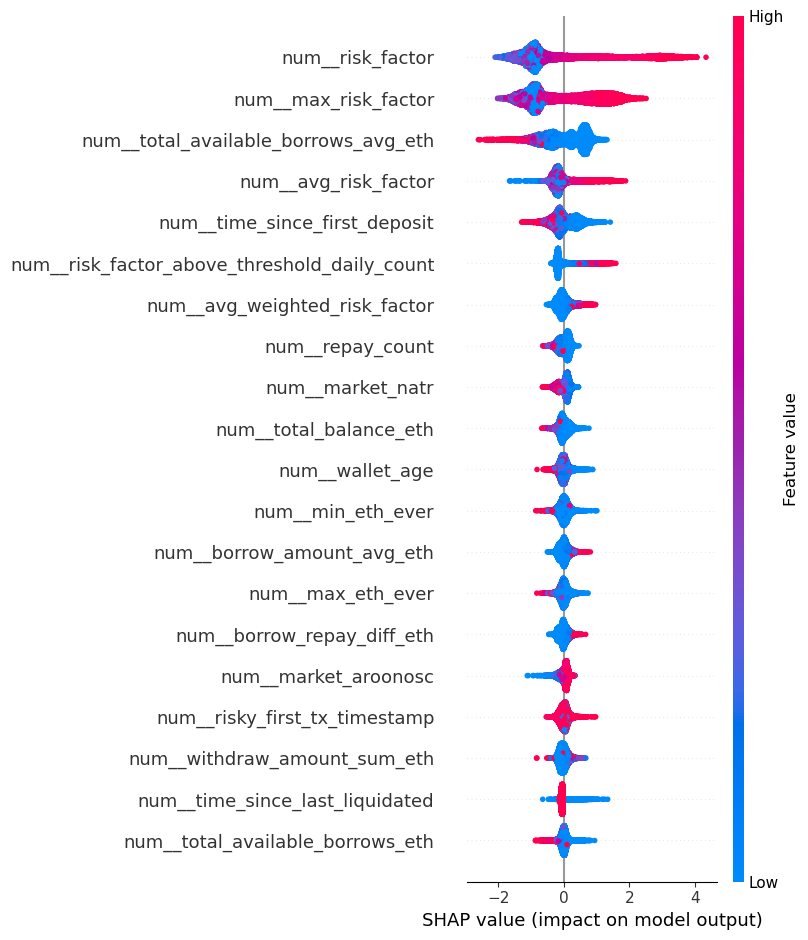

Interpretaci√≥n para una observaci√≥n espec√≠fica (ejemplo: primera fila):


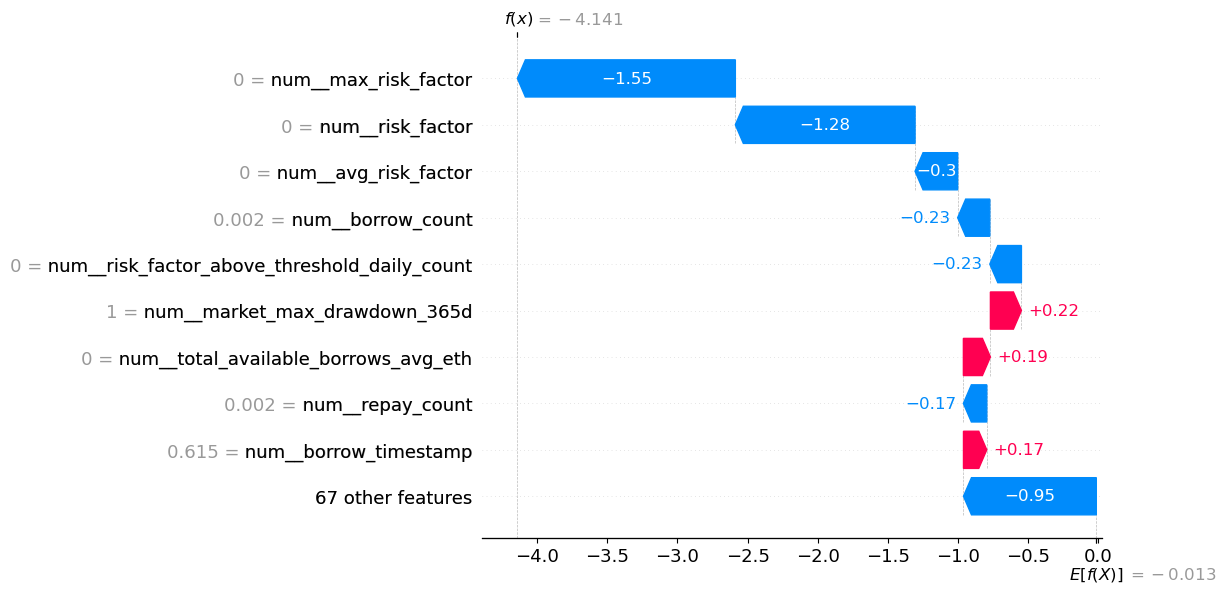

In [52]:
# Preprocesar los datos antes de aplicar SHAP
df_x_combined_processed = pipeline_xgb_completo.named_steps['preprocessing'].transform(df_x_combined)

# Extraer el modelo XGBoost entrenado del pipeline
xgb_model = pipeline_xgb_completo.named_steps['xgb_optimizado']

# Aplicar SHAP al modelo entrenado
explainer = shap.Explainer(xgb_model, df_x_combined_processed)

# Seleccionar una muestra representativa (para agilizar el tiempo de computo)
sample_fraction = 0.05
df_sample = df_x_combined_processed.sample(frac=sample_fraction, random_state=rd)

# Calcular SHAP values solo para la muestra
shap_values = explainer(df_sample)

# Generar gr√°ficos para la muestra
shap.summary_plot(shap_values, df_sample)

print("Interpretaci√≥n para una observaci√≥n espec√≠fica (ejemplo: primera fila):")
shap.waterfall_plot(shap_values[0])


Justificaci√≥n para la predicci√≥n de la instancia 0:


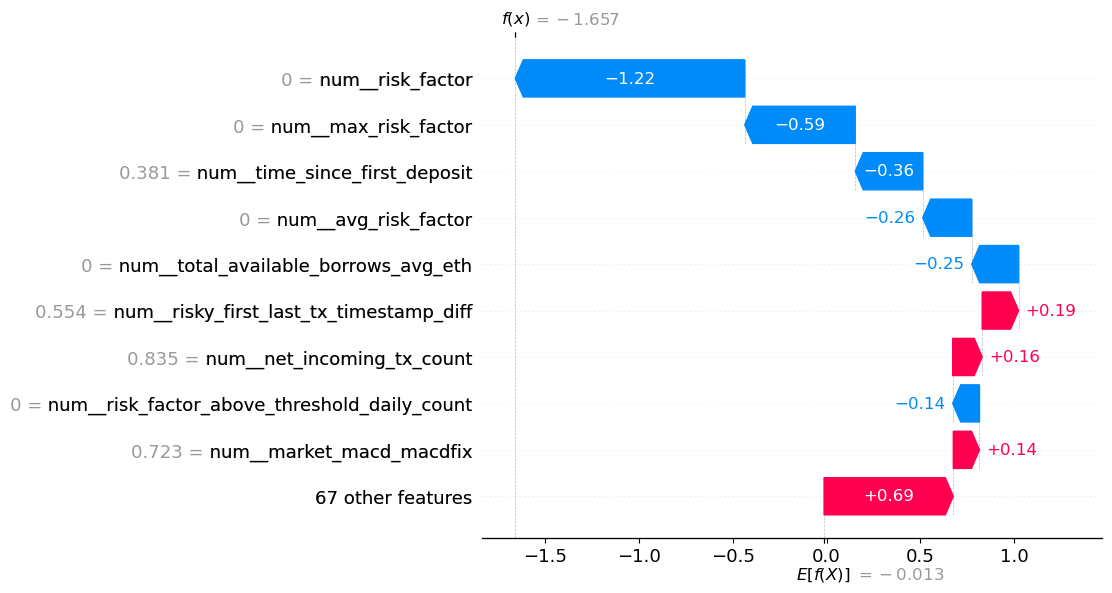


Justificaci√≥n para la predicci√≥n de la instancia 10:


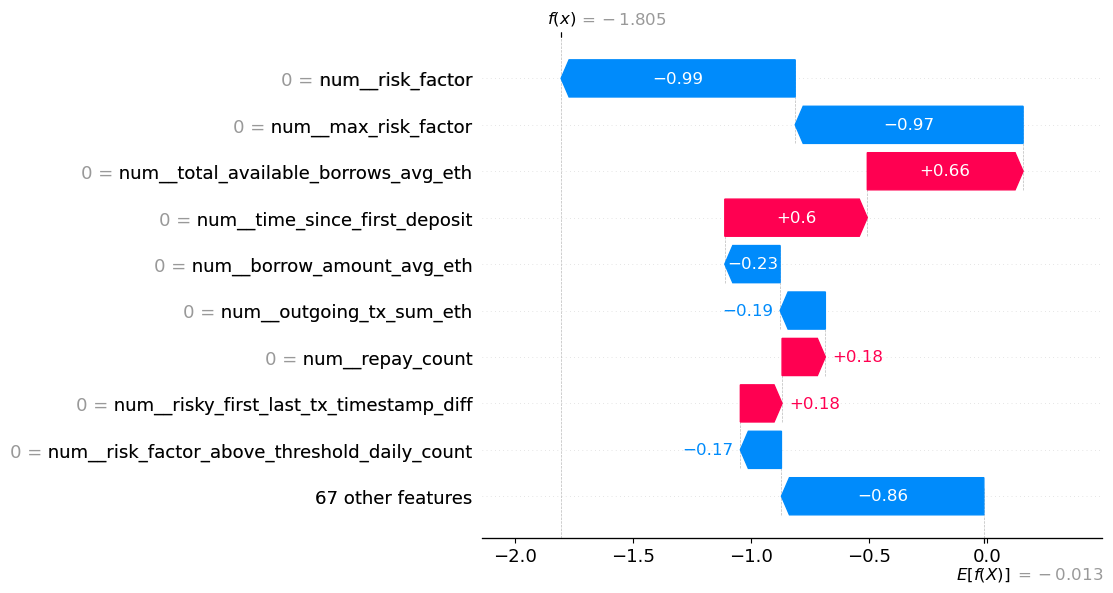


Justificaci√≥n para la predicci√≥n de la instancia 50:


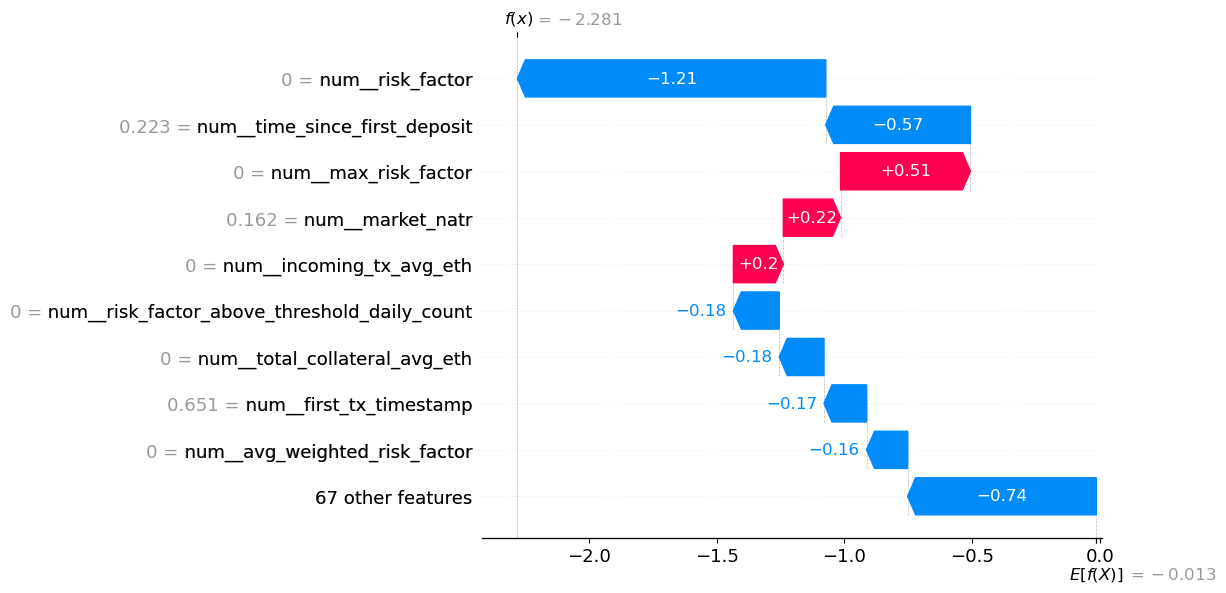

In [53]:
# Seleccionar tres instancias concretas del conjunto de prueba
indices_predicciones = [0, 10, 50] 
instancias_seleccionadas = X_test.iloc[indices_predicciones]

# Transformar las instancias seleccionadas usando el preprocesamiento del pipeline
instancias_transformadas = pipeline_xgb_completo.named_steps['preprocessing'].transform(instancias_seleccionadas)

# Calcular los SHAP values para las instancias seleccionadas
shap_values_seleccionados = explainer(instancias_transformadas)

# Generar justificaciones para cada predicci√≥n seleccionada
for i, idx in enumerate(indices_predicciones):
    print(f"\nJustificaci√≥n para la predicci√≥n de la instancia {idx}:")
    shap.waterfall_plot(shap_values_seleccionados[i])

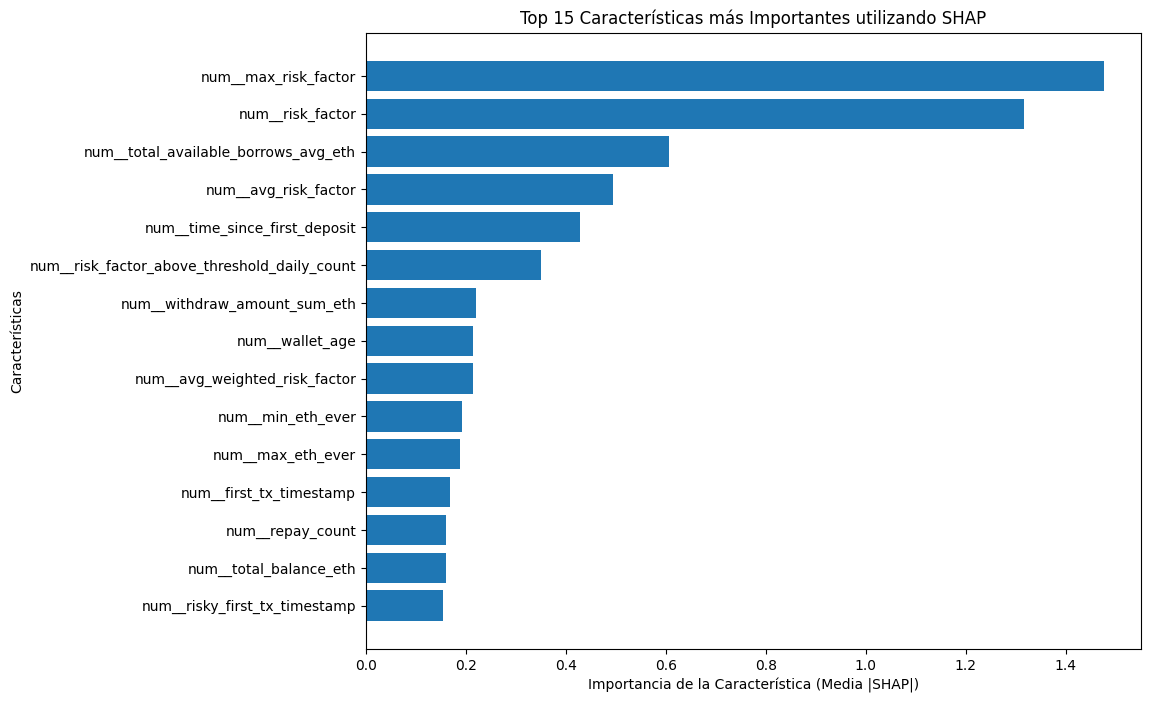

In [ ]:
# Calcular la importancia de las caracter√≠sticas utilizando los SHAP values
shap_values_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Crear un DataFrame con las caracter√≠sticas y su importancia
importance_df = pd.DataFrame({
    'feature': df_x_combined_processed.columns,
    'mean_importance': shap_values_abs_mean
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='mean_importance', ascending=True)

# Seleccionar las 10 caracter√≠sticas m√°s importantes
top_10_features = importance_df.nlargest(15, 'mean_importance')

# Gr√°fico de barras horizontales para las 10 caracter√≠sticas m√°s relevantes
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['feature'], top_10_features['mean_importance'], capsize=5)
plt.xlabel("Importancia de la Caracter√≠stica (Media |SHAP|)")
plt.ylabel("Caracter√≠sticas")
plt.title("Top 15 Caracter√≠sticas m√°s Importantes utilizando SHAP")
plt.gca().invert_yaxis()  
plt.show()


In [ ]:
shap.initjs()

# Ajustar los nombres manualmente 
processed_features = df_x_combined_processed.columns  

# Visualizar el impacto de las caracter√≠sticas para una observaci√≥n espec√≠fica
shap.force_plot(
    explainer.expected_value,
    shap_values.values[0, :],  # Valores SHAP para la primera observaci√≥n
    feature_names=processed_features
)

---

## **MLOPS**

### **Tracking con MLFlow**

Durante el proceso de modelamiento del proyecto, se cumpli√≥ con el seguimiento detallado de los elementos generados, utilizando MLflow como herramienta principal. Se rastrearon experimentos, entrenamientos y versiones de los modelos, registrando m√©tricas de desempe√±o como AUC-PR, precisi√≥n, recall y F1-score, as√≠ como los hiperpar√°metros clave utilizados en cada ejecuci√≥n. Adem√°s, se documentaron y optimizaron los modelos a trav√©s de herramientas como Optuna, asegurando interpretabilidad y trazabilidad en todas las etapas del pipeline. 

#### **Experimentos**

A lo largo del desarrollo del proyecto, se realizaron tres experimentos principales, correspondientes a las tres etapas del proyecto:

##### **1. Etapa 1: Exploraci√≥n y Selecci√≥n de Modelos**
- **Nombre del Experimento**: `Etapa 1 Proyecto`
- **Runs Principales**:
  1. `XGBoost - Primera Iteraci√≥n`
  2. `LightGBM - Primera Iteraci√≥n`
  3. `CatBoost - Primera Iteraci√≥n`
  4. `Regresi√≥n Log√≠stica - Primera Iteraci√≥n`
- **Prop√≥sito**:
  - Comparar diferentes algoritmos de aprendizaje supervisado para identificar el m√°s prometedor en t√©rminos de desempe√±o inicial.
  - M√©trica utilizada: AUC-PR, F1-Score, Precision y Recall.
- **Duraci√≥n**:
  - Vari√≥ seg√∫n el modelo. Por ejemplo, el entrenamiento de XGBoost dur√≥ **17.7 minutos**, el cual fue el modelo con mejor desempe√±o.


##### **2. Etapa 2: Reentrenamiento**
- **Nombre del Experimento**: `Etapa 2 Proyecto`
- **Runs Principales**:
  1. `XGBoost - Reentrenamiento con Datos Adicionales` (dos ejecuciones, con y sin subsampling).
- **Prop√≥sito**:
  - Evaluar el impacto del uso de datos adicionales en el desempe√±o del modelo base.
  - Ajustar el modelo entrenado previamente para incorporar m√°s informaci√≥n.
- **Resultados**:
  - El modelo sin balanceo de clases fue el m√°s efectivo.


##### **3. Etapa 3: Optimizaci√≥n y Pipeline Final**
- **Nombre del Experimento**: `Etapa 3 Proyecto`
- **Runs Principales**:
  1. `Optuna Optimization`
  2. `XGBoost Pipeline - Entrenamiento Completo`
  3. `XGBoost - Reentrenamiento con Todos los Datos` (dos ejecuciones).
- **Prop√≥sito**:
  - Realizar una optimizaci√≥n de hiperpar√°metros utilizando Optuna.
  - Integrar todo el pipeline, incluyendo preprocesamiento y el modelo final.
  - Crear un modelo robusto para la entrega final.
- **Resultados**:
  - El experimento `XGBoost Pipeline - Entrenamiento Completo` alcanz√≥ un desempe√±o satisfactorio.
  - M√©tricas registradas: AUC-PR, precisi√≥n, recall, y F1-score.


#### Elementos Rastreados

En cada etapa se rastrearon los siguientes elementos mediante MLflow:
- **Hiperpar√°metros**:
  - Principalmente `learning_rate`, `max_depth`, `n_estimators`, `reg_alpha`, `reg_lambda`, `subsample`, de XGboost, el modelo principalmente utilizado.
- **M√©tricas**:
  - **AUC-PR**: M√©trica personalizada implementada para todas las etapas.
  - **Precisi√≥n**, **Recall**, y **F1-score**: Especialmente relevantes para la evaluaci√≥n de modelos en etapas avanzadas.

#### Conclusiones

1. **Etapa 1** permiti√≥ seleccionar XGBoost como el modelo m√°s prometedor basado en m√©tricas de desempe√±o inicial.
2. **Etapa 2** se utiliz√≥ reentrenamiento con datos adicionales para mejorar el modelo de la etapa anterior.
3. **Etapa 3** culmin√≥ con un pipeline final robusto, probando optimizaciones con Optuna y validado con m√∫ltiples m√©tricas, lo que permiti√≥ obtener un modelo satisfactorio para la entrega final.

### Desarrollo de Aplicaci√≥n Web

---
## **Resultados**

#### **Desempe√±o de los modelos y evoluci√≥n a lo largo de las iteraciones**
1. **Primera Iteraci√≥n (Etapa 1):**
   - Explica brevemente los modelos iniciales probados (e.g., XGBoost, LightGBM, etc.).
   - Indica las m√©tricas clave alcanzadas (e.g., AUC-PR, F1-Score).
   - Discute el desempe√±o inicial en t√©rminos de identificar el problema (e.g., desequilibrios en las clases, resultados prometedores o desaf√≠os encontrados).

2. **Segunda Iteraci√≥n (Etapa 2):**
   - Explica c√≥mo se introdujo el reentrenamiento con nuevos datos y las t√©cnicas utilizadas para balancear las clases.
   - Resume las m√©tricas obtenidas y comp√°ralas con la etapa anterior.
   - Menciona si las t√©cnicas de reentrenamiento mejoraron o no el desempe√±o general y por qu√©.

3. **Tercera Iteraci√≥n (Etapa 3):**
   - Describe los ajustes finales, incluyendo la optimizaci√≥n de hiperpar√°metros con Optuna.
   - Discute c√≥mo los modelos optimizados superaron a las iteraciones anteriores (o no) y por qu√©.
   - Presenta las m√©tricas finales y menciona si se logr√≥ cumplir con los objetivos planteados al inicio del proyecto.



#### **Significado de los resultados en t√©rminos pr√°cticos**
- Explica c√≥mo los resultados obtenidos pueden ser utilizados en el problema real.
- Discute si las predicciones son lo suficientemente confiables para la implementaci√≥n pr√°ctica.



#### **An√°lisis t√©cnico**
1. **Fen√≥menos observados y explicaciones t√©cnicas:**
   - Describe patrones encontrados (e.g., cu√°les hiperpar√°metros tuvieron mayor impacto seg√∫n Optuna, importancia de las features seg√∫n SHAP, etc.).
   - Menciona c√≥mo ciertos ajustes mitigaron problemas como overfitting o underfitting.

2. **Factores cr√≠ticos en el desempe√±o:**
   - Comenta sobre las t√©cnicas de preprocesamiento y balanceo de clases y su contribuci√≥n.
   - Explica c√≥mo la selecci√≥n del modelo final (basado en m√©tricas y optimizaci√≥n) permiti√≥ obtener resultados satisfactorios.



#### **Conclusi√≥n general**
- Resume los hallazgos principales.
- Menciona si los resultados finales son satisfactorios y est√°n alineados con las expectativas del proyecto.
- Indica c√≥mo estos resultados respaldaron la entrega realizada en CodaLab o cualquier otra plataforma.


---
## **Conclusiones**

#### **Identificaci√≥n de los modelos con mejor desempe√±o**
Durante el proyecto, se realizaron experimentos exhaustivos para identificar los modelos con mayor capacidad de abordar el problema planteado. Tras una serie de iteraciones:
- **Etapa 1** permiti√≥ seleccionar **XGBoost** como el modelo m√°s prometedor debido a su desempe√±o superior en m√©tricas como AUC-PR y F1-score en comparaci√≥n con otros algoritmos como LightGBM y CatBoost.
- En **Etapa 2**, el reentrenamiento con datos adicionales proporcion√≥ una mejora en los resultados, destac√°ndose la versi√≥n sin balanceo de clases por su mejor desempe√±o en el conjunto de prueba.
- Finalmente, en **Etapa 3**, el modelo **XGBoost** con los hiperpar√°metros de la etapa 1 alcanz√≥ m√©tricas satisfactorias para la entrega final.

#### **Observaciones generales sobre los datos y la problem√°tica**
- El desequilibrio de clases represent√≥ un desaf√≠o significativo, especialmente en las dos √∫ltimas iteraciones. Para esto se emplearon t√©cnicas como el uso de subsampling para mejorar la representatividad de las clases minoritarias, aunque sin √©xito.
- Los datos adicionales proporcionados en las etapas avanzadas permitieron capturar m√°s patrones y mejorar el rendimiento del modelo en general.
- El uso de AUC-PR fue crucial para evaluar adecuadamente el desempe√±o de los modelos en un contexto con clases desbalanceadas.
- **Limitaciones detectadas** debido a la limitaci√≥n de tiempo y computo: 
  - No se intent√≥ crear nuevas categor√≠as a partir de las variables existentes.
  - No se redujo la dimensionalidad ni se eliminaron posibles outliers en los datos.
  - El uso de m√°s modelos y recursos podr√≠a haber permitido una optimizaci√≥n m√°s exhaustiva con Optuna, mejorando potencialmente los resultados finales.

#### **Reflexiones sobre las herramientas y t√©cnicas utilizadas**
- **MLflow** fue una herramienta clave para el seguimiento de experimentos, permitiendo rastrear m√©tricas, hiperpar√°metros y versiones de los modelos, lo que facilit√≥ la comparaci√≥n entre diferentes enfoques.
- **Optuna** fue importante para la optimizaci√≥n de hiperpar√°metros en la etapa final, identificando configuraciones que mejoraron significativamente el desempe√±o del modelo y los hiperpar√°metros m√°s relevantes. Con la limitaci√≥n de que con m√°s capacidad de computo se podr√≠a haber llegado a un resultado mejor.
- El enfoque de integraci√≥n los pipelines combinando preprocesamiento y modelado, result√≥ en un flujo reproducible y escalable para futuras implementaciones.
- Aunque en general las herramientas utilizadas fueron eficaces, el proceso de optimizaci√≥n y entrenamiento present√≥ limitaciones en t√©rminos de tiempo de c√≥mputo, lo que podr√≠a mejorarse con recursos m√°s avanzados.
- Si bien los resultados obtenidos en la competencia fueron buenos, el desempe√±o podr√≠a haberse mejorado con exploraciones adicionales y un enfoque m√°s amplio de optimizaci√≥n.

#### **Visi√≥n global del proyecto**
En resumen, este proyecto implement√≥ un flujo iterativo efectivo para abordar una problem√°tica compleja, avanzando desde la exploraci√≥n inicial de modelos hasta la construcci√≥n de una soluci√≥n optimizada y robusta. Decisiones clave, como la selecci√≥n de XGBoost, resultaron fundamentales para alcanzar un modelo final que cumple con los objetivos planteados. Sin embargo, la falta de una exploraci√≥n m√°s profunda de aspectos como los cambios en las distribuciones de los datos adicionales limit√≥ el potencial del modelo. Esto deja margen para mejoras futuras que podr√≠an elevar a√∫n m√°s su desempe√±o y efectividad.